In [4]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Just some frameworks to checkout:
# from fbprophet import Prophet

# from gluonts.model.deepar import DeepAREstimator
# from gluonts.trainer import Trainer

In [5]:
river_pd = pd.read_csv('river_data.csv')

print(river_pd.info())
print(river_pd.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923304 entries, 0 to 923303
Data columns (total 4 columns):
station_no     923304 non-null int64
date           923304 non-null object
discharge      923304 non-null float64
water_level    923304 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 28.2+ MB
None
         station_no      discharge    water_level
count  9.233040e+05  923304.000000  923304.000000
mean   6.482084e+06     416.427735    -484.957980
std    2.563108e+05     822.960147     592.618697
min    6.335020e+06    -999.000000    -999.000000
25%    6.335116e+06      10.530000    -999.000000
50%    6.335430e+06      58.292500    -999.000000
75%    6.435060e+06     433.239000     122.283250
max    6.935540e+06   11885.000000    1064.000000


In [6]:
river_pd.date = pd.to_datetime(river_pd.date, format='%Y-%m-%d')
river_pd = river_pd.set_index('date')

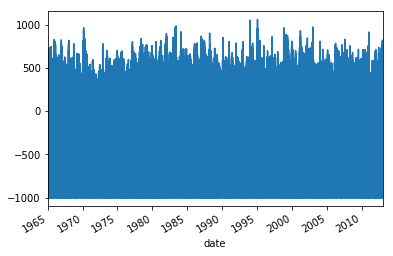

In [7]:
river_pd['water_level'].plot()


In [14]:
print((river_pd.water_level == 0.0).sum())
print(river_pd.isnull().sum())
print(river_pd.describe())

river_pd = river_pd.replace(-999.0, np.NaN)

river_pd['delta1'] = river_pd.water_level.shift(1) - river_pd.water_level
river_pd['delta2'] = river_pd.water_level.shift(2) - river_pd.water_level
river_pd['delta3'] = river_pd.water_level.shift(3) - river_pd.water_level

river_pd.head(120)
print(river_pd.isnull().sum())

4
station_no          0
discharge           0
water_level    521311
delta1         521401
delta2         521407
delta3         521420
dtype: int64
         station_no      discharge    water_level         delta1  \
count  9.233040e+05  923304.000000  401993.000000  401903.000000   
mean   6.482084e+06     416.427735     181.659994      -0.008549   
std    2.563108e+05     822.960147     139.945517      19.756533   
min    6.335020e+06    -999.000000       0.000000    -412.000000   
25%    6.335116e+06      10.530000      73.000000      -2.000000   
50%    6.335430e+06      58.292500     145.481000       1.000000   
75%    6.435060e+06     433.239000     248.000000       5.177083   
max    6.935540e+06   11885.000000    1064.000000     596.000000   

              delta2         delta3  
count  401897.000000  401884.000000  
mean       -0.016667      -0.024589  
std        32.475913      41.477551  
min      -535.000000    -563.000000  
25%        -3.223000      -5.000000  
50%         

In [16]:
river_pd.to_csv('river_data_processed.csv')